### Installing Libraries

In [95]:
!pip install -q geopy
!pip install -q geopandas
!pip install -q gensim
!pip install -q nltk

### Importing Libraries

In [105]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import nltk
nltk.download('punkt')

In [6]:
from geopy.geocoders import Nominatim
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine

### Loading the dataset

In [7]:
df = pd.read_csv("/Users/mac/Downloads/clearbit_dataset_discovered_companies.csv", low_memory=False)

### 1. Do basic analysis of the dataset using descriptive stats.

In [106]:
df

,id,name,domain,site_phonenumbers,site_emailaddresses,tags,category_sector,category_industrygroup,category_industry,category_subindustry,...,emailprovider,type,tech,techcategories,indexedat,created_at,domain_extension,category,phone_number,company_name
0,ac725f51-30dc-45c5-844f-8317152a393e,V Search,vsearch.co.in,NaN,NaN,[Human Resources],Industrials,Commercial & Professional Services,Professional Services,Human Resource & Employment Services,...,False,private,[godaddy_nameserver],[web_hosting],2021-08-05T11:20:41.603Z,5/7/2021,in,None,None,V Search
1,9428b9d0-4ed0-46b3-b85f-afa3f4f32bd0,NaN,avsnews.co.in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,personal,"[godaddy_nameserver, google_adsense, wordpress, apache]","[web_hosting, advertising, content_management_system, web_servers]",2021-08-05T13:27:37.909Z,5/7/2021,in,media,None,avsnews
2,883a4827-80e3-424f-8969-12b94be16b47,Techno5,techno5.in,[+91 79 0662 8586],[info@techno5.in],NaN,NaN,NaN,NaN,NaN,...,False,private,"[godaddy_nameserver, wordpress, asp_net, google_maps, google_analytics, google_tag_manager]","[web_hosting, content_management_system, programming_framework, geolocation, analytics, tag_management]",2021-08-05T14:11:18.273Z,5/7/2021,in,information_technology,7906628586,Techno5
3,f4d5636b-1286-4e7d-abe8-70a1729cadfd,Digital Compound,digitalcompound.in,[+91 79 0748 8830],[mail@digitalcompound.in],NaN,NaN,NaN,NaN,NaN,...,False,private,"[wordpress, nginx, facebook_connect, hubspot, facebook_advertiser, piwik, google_tag_manager]","[content_management_system, web_servers, authentication_services, marketing_automation, advertising, analytics, tag_management]",2021-08-05T15:01:21.384Z,5/7/2021,in,information_technology,7907488830,Digital Compound
4,e08dde17-3089-4179-8d58-b7e6245ef5b1,NaN,meranews24x7.in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,personal,[namecheap_dns],[dns],2021-06-21T18:31:27.352Z,5/7/2021,in,media,None,meranews24x7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33381,0a64baed-c453-4d97-82e4-cd8a2b12c436,We Dzin - India,we-dzin.com,NaN,NaN,[Architecture],Industrials,Commercial & Professional Services,Professional Services,Architecture,...,False,private,[nginx],[web_servers],2021-06-23T01:19:08.382Z,6/23/2021,com,None,None,We Dzin - India
33382,9a20e96e-7421-4d4c-bf79-9ab1e11206ea,Craftbrain Media,craftbrain.in,[+91 79 8053 0036],NaN,[Information Technology & Services],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,...,False,private,"[cloud_flare, wordpress, gravity_forms]","[dns, content_management_system, form_builder]",2021-06-23T02:11:27.980Z,6/23/2021,in,information_technology,7980530036,Craftbrain Media
33383,df7059c1-771e-48f2-8e47-54b81d947a1f,Onliine Grocery Store - Best Rice and Wheat Store,smartreads.in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,private,"[wordpress, woo_commerce]","[content_management_system, ecommerce]",2021-06-23T04:51:27.855Z,6/23/2021,in,food,None,Onliine Grocery Store - Best Rice and Wheat Store
33384,6b7d81bc-5bdd-4137-90dc-08c37c2d651c,NaN,capitalfortunes.com,"[+91 40 6603 8300, +91 80 2559 4661]","[connect@capitalfortunes.com, siddharth@capitalfortunes.com, sakthi@capitalfortunes.com]",NaN,NaN,NaN,NaN,NaN,...,False,private,"[microsoft_exchange_online, outlook, microsoft_office_365, wordpress, apache, google_maps, sap_hana, oracle_data_integrator, informatica, apache_http_server, sap_business_objects]","[email_hosting_service, productivity, content_management_system, web_servers, geolocation, database, data_management, analytics]",2021-07-24T13:51:47.237Z,6/23/2021,com,information_technology,8025594661,capitalfortunes


### Droping Non-related columns

In [11]:
df = df.drop(['legalname', 'geo_streetnumber', 'geo_streetname', 'geo_subpremise', 'identifiers_usein', 'phone', 
              'metrics_raised', 'metrics_alexausrank', 'metrics_marketcap', 'annualrevenue', 'fiscalyearend', 
              'facebook_handle', 'crunchbase_handle', 'ticker', 'parent_domain', 'ultimateparent_domain'], axis=1)


### Replacing `'[]'` with `'NaN'`

In [13]:
df.replace('[]', np.NaN, inplace=True)

In [15]:
df = df.drop(['domainaliases'], axis=1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33386 entries, 0 to 33385
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       33386 non-null  object 
 1   name                     22695 non-null  object 
 2   domain                   33386 non-null  object 
 3   site_phonenumbers        9829 non-null   object 
 4   site_emailaddresses      8820 non-null   object 
 5   tags                     7042 non-null   object 
 6   category_sector          6927 non-null   object 
 7   category_industrygroup   6927 non-null   object 
 8   category_industry        6927 non-null   object 
 9   category_subindustry     6927 non-null   object 
 10  category_siccode         5179 non-null   float64
 11  category_naicscode       5633 non-null   float64
 12  foundedyear              2230 non-null   float64
 13  timezone                 33386 non-null  object 
 14  utcoffset             

### 2. Which domains are famous among companies (in/com). Also create plot.

In [18]:
df['domain_extension'] = df['domain'].str.split('.').str[-1]
df['domain_extension']

0         in
1         in
2         in
3         in
4         in
        ... 
33381    com
33382     in
33383     in
33384    com
33385     in
Name: domain_extension, Length: 33386, dtype: object

In [19]:
df_domain_extension = df[df['domain_extension'].notnull()]
extension_counts = df_domain_extension['domain_extension'].value_counts()
extension_counts = extension_counts[:5] # Top 5 extensions
extension_counts

domain_extension
in     27749
com     4968
org      189
net       98
co        97
Name: count, dtype: int64

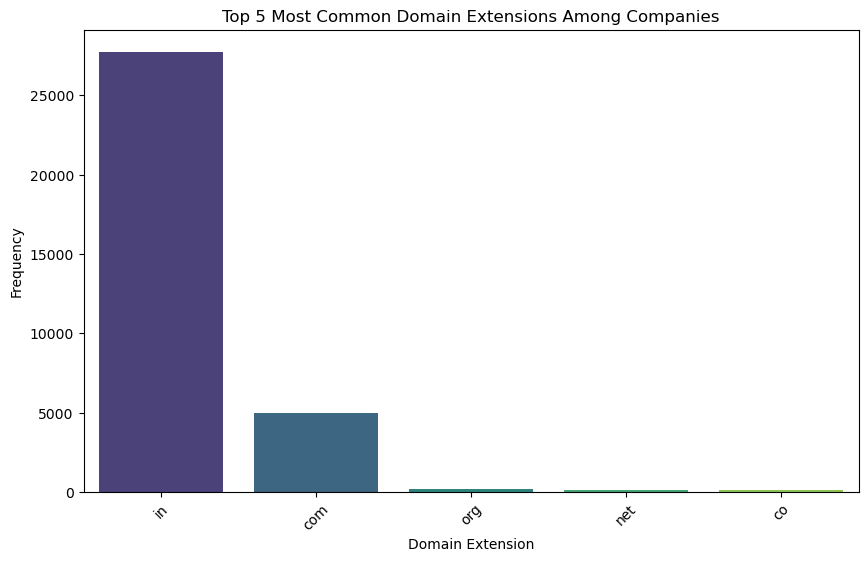

In [20]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=extension_counts.index, y=extension_counts.values, palette='viridis')
plt.title('Top 5 Most Common Domain Extensions Among Companies')
plt.xlabel('Domain Extension')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 3. Categorise companies based on their names and domain names. Like service based companies, blog, fintech etc.

In [85]:
def categorize_company(row):
    # Define the categories and their corresponding lists
    categories = {
        'information_technology': ['web', 'tech', 'IT', 'Technologies', 'technology', 'data', 'software', 'network', 'programming', 'code', 'cybersecurity', 'development', 'application', 'database', 'cloud', 'AI', 'machinelearning', 'analytics', 'Python', 'Java', 'C++', 'coding', 'ITservices', 'digital', 'automation', 'techsupport', 'ITconsulting'],
        'media': ['media', 'advertising', 'news', 'akhabaar', 'press', 'magazine', 'TV', 'radio', 'broadcasting', 'journalist', 'publication', 'journalism', 'socialmedia', 'editor', 'reporter', 'newsroom', 'mediaindustry', 'mediaproduction', 'mediaagency', 'mediaoutlet', 'mediaplatform'],
        'education': ['college', 'class', 'classes', 'institute', 'academy', '.edu', '.ac', 'skool', 'university', 'school', 'learning', 'academic', 'study', 'curriculum', 'training', 'course', 'teacher', 'student', 'degree', 'diploma', 'educationalinstitution', 'onlinelearning', 'e-learning', 'educationalresources', 'educationaltechnology', 'teaching'],
        'healthcare': ['health', 'wellness', 'clinic', 'dr', 'diagnostic', 'ayurved', 'medical', 'hospital', 'patient', 'treatment', 'therapy', 'healthcareservices', 'healthcareprovider', 'medicalcenter', 'healthcareindustry', 'healthcaretechnology', 'healthcaresolutions', 'medicalequipment', 'healthcareprofessionals'],
        'fashion': ['fashion', 'style', 'trend', 'designer', 'clothing', 'apparel', 'boutique', 'runway', 'fashionista', 'fashionindustry', 'fashiondesign', 'fashionbrand', 'fashionshow', 'fashionblog', 'fashionaccessories', 'fashioninfluencer', 'fashionmodel', 'hautecouture', 'fashionmagazine'],
        'tour_and_travel': ['tour', 'travel', 'hotel', 'trip', 'vacation', 'destination', 'tourism', 'journey', 'adventure', 'booking', 'travelagency', 'travelguide', 'travelplanner', 'traveldestination', 'travelpackage', 'holiday', 'explorer', 'sightseeing', 'travelexperience', 'travelblog', 'traveltips'],
        'electrical': ['camera', 'cctv', 'electric', 'electrical', 'electronic', 'device', 'gadget', 'appliance', 'equipment', 'electricalengineering', 'electricalcontractor', 'electricalservices', 'electricalequipment', 'electricalsystem', 'electricalwiring', 'electrician', 'electricalsafety'],
        'jewellery': ['jewelry', 'jewellers', 'jewel', 'gemstone', 'gold', 'silver', 'diamond', 'accessory', 'bracelet', 'necklace', 'jewelrystore', 'jewelrydesign', 'jewelrymaker', 'finejewelry', 'luxuryjewelry', 'customjewelry', 'fashionjewelry', 'jewelrycollection', 'jewelrybrand', 'jewelryrepair'],
        'architecture': ['real', 'estate', 'infra', 'builders', 'architect', 'construction', 'building', 'design', 'structure', 'blueprint', 'urban', 'architecturefirm', 'architecturaldesign', 'architectureservices', 'constructioncompany', 'buildingcontractor', 'realestatedeveloper', 'propertydevelopment'],
        'food': ['cake', 'food', 'eat', 'recipe', 'cafe', 'market', 'mart', 'restaurant', 'cuisine', 'chef', 'dining', 'cooking', 'gourmet', 'foodindustry', 'foodblog', 'fooddelivery', 'foodservice', 'foodcatering', 'foodmenu', 'foodtruck', 'foodbusiness', 'foodproduction', 'culinary', 'culinaryarts'],
        'entertainment': ['game', 'gamer', 'studio', 'bollywood', 'fun', 'entertainment', 'movie', 'music', 'theater', 'show', 'concert', 'performance', 'gaming', 'entertainmentindustry', 'entertainmentcenter', 'entertainmentvenue', 'entertainmentnews', 'entertainmentblog', 'entertainmentevent', 'movietheater', 'musicfestival'],
        'textile': ['mill', 'fabric', 'material', 'garment', 'weaving', 'thread', 'yarn', 'textile', 'textileindustry', 'textilemanufacturing', 'textiledesign', 'textilecompany', 'textilemachinery', 'textileproducts', 'textiletrade', 'textilebusiness', 'textileart', 'textileprinting', 'textileexporter'],
        'sporting_goods': ['sport', 'sportinggoods', 'equipment', 'gear', 'athlete', 'fitness', 'exercise', 'gym', 'sportsequipment', 'sportsgear', 'sportsapparel', 'sportinggoodsstore', 'sportsbrand', 'sportsindustry', 'sportsequipmentmanufacturer', 'sportswear', 'sportsaccessories', 'sportsclothing', 'sportsshop'],
        'fintech': ['pay', 'money', 'bank', 'finance', 'budget', 'stock', 'trading', 'invest', 'investing', 'financial', 'payment', 'banking', 'financialservices', 'financialtechnology', 'fintech', 'fintechcompany', 'fintechsolutions', 'fintechindustry', 'onlinepayment', 'digitalpayment', 'financialinstitution', 'financialadvisor', 'financialplanning', 'investmentmanagement'],
        'services': ['care', 'solution', 'solutions', 'consultancy', 'associates', 'support', 'assistance', 'advisory', 'consulting', 'partnership', 'collaboration', 'service', 'professionalservices', 'businessservices', 'consultingservices', 'advisoryservices', 'clientservices', 'customerservice', 'serviceprovider']
    }

    company_name = row['name'] if pd.notnull(row['name']) else row['domain']
    
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword.lower() in company_name.lower():
                return category
    
    return None

df['category'] = df.apply(categorize_company, axis=1)
df_categorized = df[df['category'].notnull()]
df_categorized[['name', 'domain', 'category']].reset_index(inplace=True, drop=True)
df_categorized[['name', 'domain', 'category']]

,name,domain,category
1,NaN,avsnews.co.in,media
2,Techno5,techno5.in,information_technology
3,Digital Compound,digitalcompound.in,information_technology
4,NaN,meranews24x7.in,media
5,Aay Kay Infraestate,aaykayinfraestate.com,architecture
...,...,...,...
33378,Jet Express Cargo,dhlcourierchennai.co.in,media
33380,Nidram,nidram.in,healthcare
33382,Craftbrain Media,craftbrain.in,information_technology
33383,Onliine Grocery Store - Best Rice and Wheat Store,smartreads.in,food


### 4. A list of companies and their 10 digit phone numbers.

In [86]:
# Function to extract the 10-digit phone number from a string
def extract_phone_number(phone_str):
    if isinstance(phone_str, str):
        phone_str = phone_str.replace('[', '').replace(']', '').replace(' ', '')
        for i in range(len(phone_str) - 1, -1, -1):
            if phone_str[i].isdigit() and len(phone_str[i:]) >= 10:
                return phone_str[i:i+10]
    return None

# Function to extract domain name if company is null
def extract_domain_name(row):
    if pd.isnull(row['name']):
        domain_parts = row['domain'].split('.')
        if len(domain_parts) >= 2:
            return domain_parts[0]
    return None

In [92]:
df['phone_number'] = df['site_phonenumbers'].apply(lambda x: extract_phone_number(str(x)))

df['company_name'] = df.apply(lambda row: row['name'] if not pd.isnull(row['name']) else extract_domain_name(row), axis=1)

df_company_with_phone = df[['id', 'company_name', 'phone_number']].copy()
df_company_with_phone = df_company_with_phone.dropna(subset=['id', 'company_name', 'phone_number'])
df_company_with_phone.reset_index(inplace=True, drop=True)
df_company_with_phone

,id,company_name,phone_number
0,883a4827-80e3-424f-8969-12b94be16b47,Techno5,7906628586
1,f4d5636b-1286-4e7d-abe8-70a1729cadfd,Digital Compound,7907488830
2,a2641370-51e5-4d7e-8d86-cd15516b4674,Aay Kay Infraestate,5224044778
3,5114327b-efde-4c2b-a091-3b9b572c8800,Vintage Fashions,8006645555
4,765bec07-9a24-4e74-9a45-d48da1551fd1,handlair,7042898442
...,...,...,...
9824,69374485-e5b6-4fc7-889b-e3f0b87cab93,IntegerHouse,9995388784
9825,f4c77ff7-ef86-42b3-a748-1f2af54b66b9,Jet Express Cargo,4442059930
9826,52089756-c969-4899-9c47-a0274804ddfd,Nidram,9011036289
9827,9a20e96e-7421-4d4c-bf79-9ab1e11206ea,Craftbrain Media,7980530036


### 5. Which email names are popular among companies(admin/info) etc. Also plot it.

In [24]:
email_names = []
for emails_str in df['site_emailaddresses']:
    if isinstance(emails_str, str):
        emails_list = emails_str.replace('[', '').replace(']', '').split(', ')
        for email in emails_list:
            email_names.append(email.split('@')[0])

email_name_counts = pd.Series(email_names).value_counts()
email_name_counts = email_name_counts[:5]
email_name_counts

info       3802
support    1151
contact     871
sales       545
hello       326
Name: count, dtype: int64

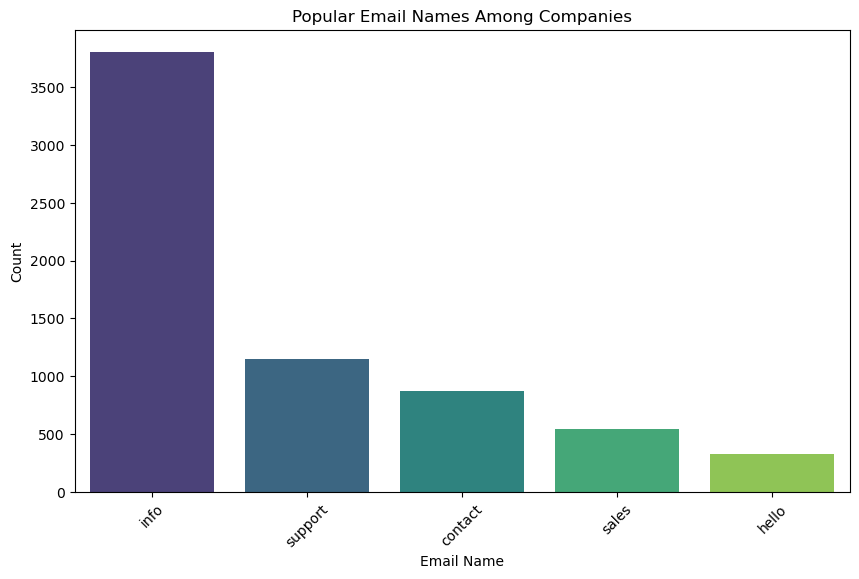

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=email_name_counts.index, y=email_name_counts.values, palette='viridis')
plt.xlabel('Email Name')
plt.ylabel('Count')
plt.title('Popular Email Names Among Companies')
plt.xticks(rotation=45)
plt.show()

### 6. Categorise companies in different sectors with plots.

In [26]:
df_sector = df[df['category_sector'].notnull()]

In [27]:
sector_counts = df_sector['category_sector'].value_counts()
sector_counts

category_sector
Consumer Discretionary        2821
Information Technology        1496
Industrials                   1310
Health Care                    406
Financials                     386
Materials                      205
Consumer Staples               171
Utilities                       75
Telecommunication Services      29
Energy                          28
Name: count, dtype: int64

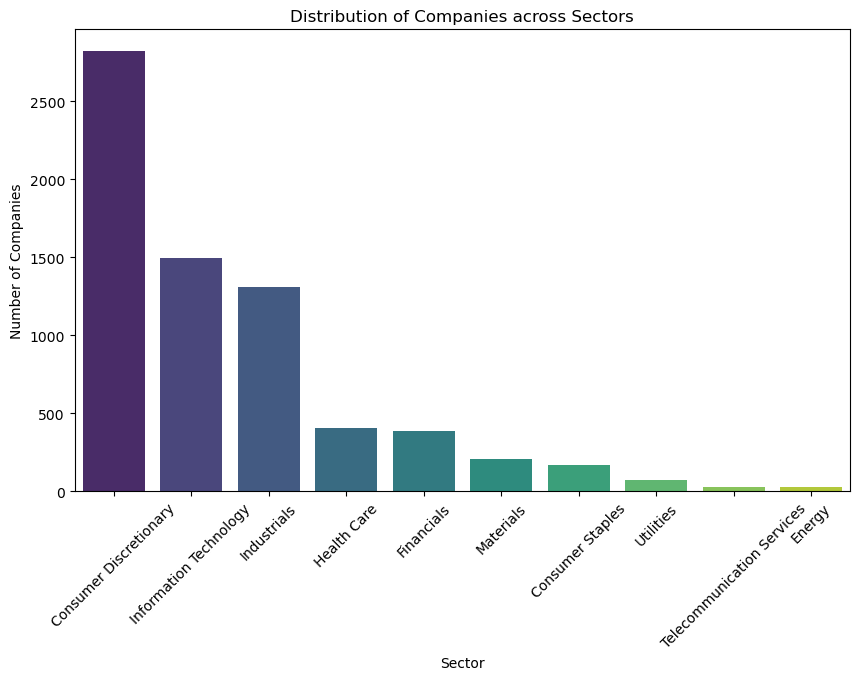

In [93]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, palette='viridis')
plt.title('Distribution of Companies across Sectors')
plt.xlabel('Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

### 7. Plot companies on India’s map based on their location.

In [115]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
india = world[world.name == 'India']
indian_companies = df[df['geo_countrycode'] == 'IN']

gdf = gpd.GeoDataFrame(indian_companies, geometry=gpd.points_from_xy(indian_companies['geo_lng'], indian_companies['geo_lat']))

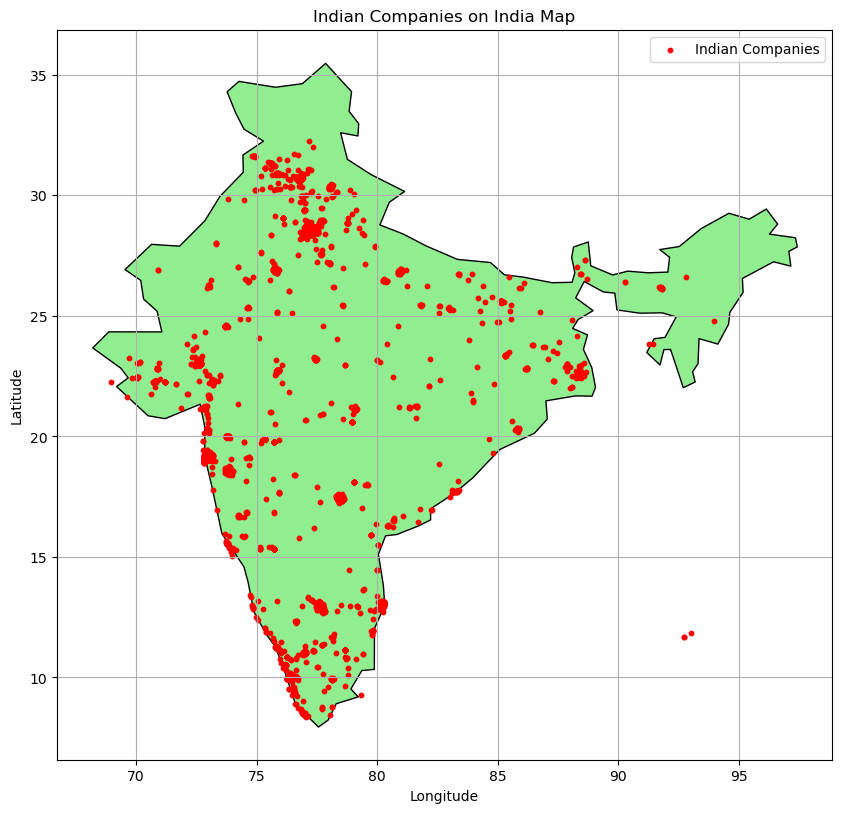

In [114]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
india.plot(ax=ax, color='lightgreen', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=10, label='Indian Companies')
ax.set_title('Indian Companies on India Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


### 8. Which state and cities are leading in number of companies.

### Cities with leading companies

In [32]:
df_city = df[df['geo_city'].notnull()]
city_counts = df_city['geo_city'].value_counts()
city_counts = city_counts[:10]
city_counts

geo_city
Bengaluru    591
New Delhi    590
Mumbai       560
Chennai      287
Hyderabad    279
Pune         239
Kolkata      196
Ahmedabad    195
Gurugram     168
Noida        160
Name: count, dtype: int64

### States with leading companies

In [33]:
df_state = df[df['geo_state'].notnull()]
state_counts = df_state['geo_state'].value_counts()
state_counts = state_counts[:10]
state_counts

geo_state
Maharashtra      1175
Delhi             766
Karnataka         657
Tamil Nadu        461
Gujarat           422
Uttar Pradesh     390
Telangana         343
Haryana           281
West Bengal       235
Rajasthan         197
Name: count, dtype: int64

### 9. Plot companies according to size of their revenue.

In [34]:
df_revenue = df[df['estimatedannualrevenue'].notnull()]
company_counts = df_revenue['estimatedannualrevenue'].value_counts()
company_counts


estimatedannualrevenue
$0-$1M         3740
$1M-$10M       1804
$10M-$50M       724
$50M-$100M      282
$100M-$250M      18
$250M-$500M       4
$1B-$10B          3
$500M-$1B         3
$10B+             2
Name: count, dtype: int64

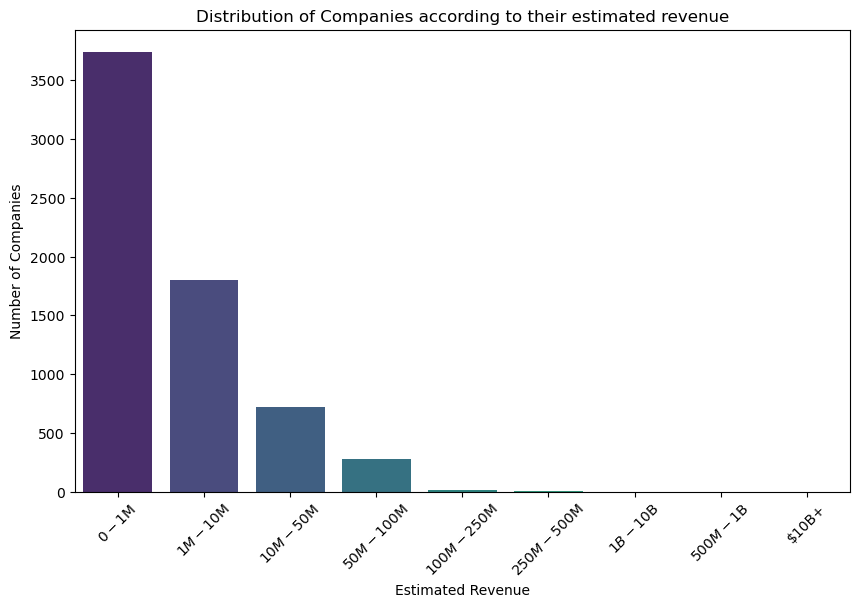

In [103]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=company_counts.index, y=company_counts.values, palette='viridis')
plt.title('Distribution of Companies according to their estimated revenue')
plt.xlabel('Estimated Revenue')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()


### 10. Finally select useful features that could be used to classify similarity among companies and create embeddings for them.

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

In [39]:
selected_features = ['company_name', 'tags', 'category_sector', 'category_industrygroup', 'category_industry', 'category_subindustry', 'category_siccode', 'techcategories']
df_selected = df[selected_features].fillna('')
df_selected_without_exclude = df_selected[selected_features].drop(columns=['company_name'])
df_selected['combined_features'] = df_selected_without_exclude.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


In [40]:
df_selected['combined_features'] = df_selected['combined_features'].apply(lambda x: x.replace('[', '').replace(']', ''))


In [49]:
features = df_selected['combined_features'].tolist()

In [51]:

tokenized_features = [word_tokenize(sentence) for sentence in features]


In [53]:
word2vec_model = Word2Vec(tokenized_features, vector_size=100, window=5, min_count=1, sg=0)

In [54]:
# Function to generate embeddings for a combined feature
def generate_embedding(combined_features):
    embedding = np.zeros(word2vec_model.vector_size)
    count = 0
    for word in combined_features.split():
        if word in word2vec_model.wv:
            embedding += word2vec_model.wv[word]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

df_selected['embeddings'] = df_selected['combined_features'].apply(generate_embedding)

In [109]:
df_selected[['company_name', 'combined_features']]

,company_name,combined_features
0,V Search,Human Resources Industrials Commercial & Professional Services Professional Services Human Resource & Employment Services 73.0 web_hosting
1,avsnews,"web_hosting, advertising, content_management_system, web_servers"
2,Techno5,"web_hosting, content_management_system, programming_framework, geolocation, analytics, tag_management"
3,Digital Compound,"content_management_system, web_servers, authentication_services, marketing_automation, advertising, analytics, tag_management"
4,meranews24x7,dns
...,...,...
33381,We Dzin - India,Architecture Industrials Commercial & Professional Services Professional Services Architecture 87.0 web_servers
33382,Craftbrain Media,"Information Technology & Services Information Technology Software & Services Internet Software & Services Internet Software & Services 48.0 dns, content_management_system, form_builder"
33383,Onliine Grocery Store - Best Rice and Wheat Store,"content_management_system, ecommerce"
33384,capitalfortunes,"email_hosting_service, productivity, content_management_system, web_servers, geolocation, database, data_management, analytics"


In [112]:
company_name_1 = input("Enter the first company name: ")
company_name_2 = input("Enter the second company name: ")

try:
    comp1_embeddings = df_selected.loc[df_selected['company_name'] == f'{company_name_1}', 'embeddings'].values[0]
    comp2_embeddings = df_selected.loc[df_selected['company_name'] == f'{company_name_2}', 'embeddings'].values[0]
    similarity_score = 1-cosine(comp1_embeddings, comp2_embeddings)
    print(f"\nSimilarity Score between the {company_name_1} and {company_name_2}:", similarity_score)
except Exception as e:
    print("\nAn error occurred, Company name does not exists")

Enter the first company name: avsnews
Enter the second company name: meranews24x7

Similarity Score between the avsnews and meranews24x7: 0.7450445620045351
